# Imports

In [1]:
import numpy as np
from sklearn import datasets
from sklearn import metrics
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import math
import skfuzzy as fuzz 
import re


plt.rcParams['figure.figsize'] = [6,4]
%matplotlib inline

In [2]:
# Load the Iris dataset
iris = datasets.load_iris()

# Convert the Iris dataset to a Pandas DataFrame
iris_df = pd.DataFrame(data=iris.data, columns=iris.feature_names)
iris_df['target'] = iris.target

data = iris.data
target = iris.target

In [3]:
iris_df

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0
...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2
146,6.3,2.5,5.0,1.9,2
147,6.5,3.0,5.2,2.0,2
148,6.2,3.4,5.4,2.3,2


In [4]:
iris_df.describe()

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
count,150.000000,150.000000,150.000000,150.000000,150.000000
mean,5.843333,3.057333,3.758000,1.199333,1.000000
std,0.828066,0.435866,1.765298,0.762238,0.819232
min,4.300000,2.000000,1.000000,0.100000,0.000000
25%,5.100000,2.800000,1.600000,0.300000,0.000000
50%,5.800000,3.000000,4.350000,1.300000,1.000000
75%,6.400000,3.300000,5.100000,1.800000,2.000000
max,7.900000,4.400000,6.900000,2.500000,2.000000


In [5]:
iris_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150 entries, 0 to 149
Data columns (total 5 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   sepal length (cm)  150 non-null    float64
 1   sepal width (cm)   150 non-null    float64
 2   petal length (cm)  150 non-null    float64
 3   petal width (cm)   150 non-null    float64
 4   target             150 non-null    int32  
dtypes: float64(4), int32(1)
memory usage: 5.4 KB


## Membership functions

In [6]:
# function to produce prob of a gaussian
def gaussian(X, mu, sigma):
    '''Get pdf over X'''
    return np.exp(-((X - mu) ** 2.) / float(sigma) ** 2.)

In [7]:
def trapezoid(X, a, b, c, d):
    """
    Generate a trapezoid function.

    Parameters:
    X (numpy.ndarray): Input values.
    a (float): Left start of the trapezoid.
    b (float): Left end of the flat top.
    c (float): Right end of the flat top
    d (float): Right end of the trapezoid.

    Returns:
    numpy.ndarray: Trapezoid function values.
    """
    return np.where((X < a) | (X > d), 0.0,
                    np.where((X >= a) & (X < b), (X - a) / (b - a),
                             np.where((X >= b) & (X <= c), 1.0,
                                      np.where((X > c) & (X <= d), (d - X) / (d - c), 0.0))))

In [8]:
def trimf(x, a, b, c):
    assert a<=b<=c<=x[-1], "Vertices need to be positioned properly"

    y = np.zeros_like(x)

    # left side
    if a!=b:
        left_slope = 1/(b-a)
        idx = np.nonzero(np.logical_and(a<=x, x<=b))

        y[idx] = left_slope*(x[idx] - a)
    
    else:
        idx = np.nonzero(x==a)
        y[idx] = 1

    # right side
    if b!=c:
        right_slope = -1/(c-b)

        idx = np.nonzero(np.logical_and(b<=x, x<=c))
        y[idx] = right_slope*(x[idx] - b) + 1
    
    else:
        idx = np.nonzero(x==c)
        y[idx] = 1
    
    return y
    

# Interpolate membership of data

In [9]:
# function to get membership value of datum in a subset
def interp_mem_val(subset_arr, X, datum):
    '''Get membership of data in subset'''
        
    # convert universe of discourse (list) to a numpy array
    X_array = np.asarray(X)
    # find the nearest two points
    l = X_array[X_array <= datum][-1] # grab value immediately below data
    u = X_array[X_array >= datum][0] # grab value immediately above data

    idl = np.nonzero(X_array == l)[0][0] # grab index of value immediately below data
    idu = np.nonzero(X_array == u)[0][0] # grab index of value immediately above data

    if idl==idu:
        id = idl
        mem_val = subset_arr[id]
        return round(mem_val,5)
    
    lower_mv = subset_arr[idl]
    upper_mv = subset_arr[idu]

    slope = (upper_mv - lower_mv) / float(u - l)
    mem_val = slope * (datum - l) + lower_mv

    return round(mem_val,5)


# function to get membership value of every datum of a data array in a subset (type ndarray)
def interp_mem_val_of_data_array_in_subset(subset_arr, X, data_arr):
    mem_vals = []

    for datum in data_arr:
        mem_vals.append(interp_mem_val(subset_arr, X, datum))
    
    return mem_vals


# function to get membership value of a datum in all subsets provided in a dictionary
def interp_mem_val_of_datum_in_subsets(subset_dict, X, data):
    
    mem_val_in_all_subsets = {}

    for subset in subset_dict:
        mv = interp_mem_val(subset_dict[subset], X, data)
        mem_val_in_all_subsets[f'{subset}'] = mv
    
    return mem_val_in_all_subsets



def interp_mem_vals_of_data_all_subsets(subset_dict, X, data_arr):
    
    # create a dictionary to keep membership values of all data in all subsets
    mem_vals_of_data_in_all_subsets = {}

    # loop through data
    for datum in data_arr:

        # check if datum already exists in dict
        if datum in mem_vals_of_data_in_all_subsets.keys():
            continue

        datum_mem_values_dict = interp_mem_val_of_datum_in_subsets(subset_dict, X, datum)
        mem_vals_of_data_in_all_subsets[datum] = datum_mem_values_dict
    
    return mem_vals_of_data_in_all_subsets


def dict_of_dicts_to_dataframe(dict_of_dict):
    """
    Convert a dictionary of dictionaries to a pandas DataFrame.

    Args:
        dict_of_dict (dict): The dictionary of dictionaries.

    Returns:
        pd.DataFrame: The resulting DataFrame.
    """
    # Create a list of dictionaries for DataFrame construction
    data_list = [{'Data point': key, **inner_dict} for key, inner_dict in dict_of_dict.items()]

    # Convert the list of dictionaries to a DataFrame
    df = pd.DataFrame(data_list)

    return df
    


Store subsets of different domains in different dictionaries

# Rules

In [10]:
def get_antecedents_and_consequent(rule_str):
    '''
    Args:
        rule_str (the rule)
    Returns:
        number of antecedents in the rule, a list containing the antecedents and the consequent
    '''
    if 'THEN' not in rule_str:
        print(f"rule '{rule_str}' must have 'THEN' keyword" )
        
    rule_split = rule_str.split("THEN")
    
    antecedent_sentence = rule_split[0][2:].strip()
    consequent_sentence = rule_split[1].strip()


    # Split the sentence using a regular expression that matches 'AND', 'OR', or 'NOT'
    split_antecedent = re.split(r'\b(?:AND|OR)\b', antecedent_sentence)

    # remove leading and trailing white spaces
    cleaned_antecedent = [antecedent.strip() for antecedent in split_antecedent]
    antecedent_n = len(cleaned_antecedent)

    result = [antecedent_n, cleaned_antecedent, consequent_sentence.strip()]

    return result

def validate_rule(rule_str):
    # Define the pattern for validation
    pattern_antecedent = r'(sepal length|sepal width|petal length|petal width) is (VLOW|LOW|MED|HIGH)$'
    pattern_consequent = r'class (0|1|2) is (LOW|MED|HIGH)$'

    antecedents, consequent = get_antecedents_and_consequent(rule_str)[1], get_antecedents_and_consequent(rule_str)[2]
    
    # validate antecedents
    for antecedent in antecedents:
        assert re.match(pattern_antecedent, antecedent), f"'{antecedent}' is not a valid antecedent."

    # validate consequent
    assert re.match(pattern_consequent, consequent), f"'{consequent}' is not a valid consequent"


def validate_rule_base(rule_base):
    for rule in rule_base:
        validate_rule(rule)


def matching_rule(rule_base, rule_str):
    '''Search if a rule already exists with the same antecedents or consequent and handle the rule. Handling
    depends on a few rules
    1. If the ENTIRE antecedent is same but consequent is different, ask user to choose which rule to keep and remove the other.
    2. If the collection of antecedents is different then do nothing.
    3. If the ENTIRE antecedent is different but the consequent is the same, then add this new antecedent with an OR.
        a. If single antecedent is same, use 1.
        b. If no single antecedent is same, add with an OR
    4. If the antecedent AND consequent is diffierent, do nothing.'''

    # First check if entire antecedent is same
    split_rule = rule_str.split("THEN")
    antecedent1 = split_rule[0]
    consequent1 = split_rule[1]

    for rule in rule_base:
        
        antecedent2 = rule.split("THEN")[0]
        consequent2 = rule.split("THEN")[1]

        if antecedent1 == antecedent2: # same antecedent
            if consequent1 == consequent2: # same antecedent, same consequent
                print(f"New rule '{rule_str}' already exists: {rule}")
                
                return None
            
            # else:
            #     print(f"New rule '{rule_str}' contradicts old rule '{rule}' ")
            #     choice = input(f"Which do you want to keep? \n \
            #           1. {rule_str} \
            #           2. {rule}")
                
            #     if choice == 1:
            #         rule_base.remove(rule)
            #         return rule_str
                
            #     elif choice == 2:
            #         rule_base.remove(rule)
            #         return rule
                
        else:
            if consequent1 == consequent2: # different antecedent, same consequent
                # print message
                print("Rule with same consquent exists. Thus, previous rule will be extended with this rule with an OR")
                print(f"Old rule: {rule} \nCurrent rule: {rule_str}")

                # create an extended rule
                extended_rule = antecedent2 + "OR" + antecedent1[2:] + "THEN" + consequent1 # add rule without the "IF ... "
                print(f"New rule: {extended_rule}")

                return extended_rule
            
            else:
                return None



def add_rule(rule_base, rule_str):
    """Add rule to rule base"""

    # validate rule
    validate_rule(rule_str) 
    rule = matching_rule(rule_base, rule_str)

    if rule != None:
        rule_base.append(rule)
    else:
        rule_base.append(rule_str)


def determine_antecedent_vars(rule_str):
    '''
    Args:
        the rule
    Returns:
        A dictionary of True/False values indicating which linguistic variables are used in antecedent
    '''

    linguistic_vars = {"sepal length":False, "sepal width": False, "petal length": False, "petal width": False}

    for linguistic_var in linguistic_vars.keys():
        if linguistic_var in rule_str:
            linguistic_vars[linguistic_var] = True
            
    return linguistic_vars


In [11]:
rule_base_x = []
add_rule(rule_base_x, "IF petal length is LOW THEN class 2 is HIGH")
add_rule(rule_base_x, "IF petal length is LOW AND petal width is LOW THEN class 2 is HIGH")

Rule with same consquent exists. Thus, previous rule will be extended with this rule with an OR
Old rule: IF petal length is LOW THEN class 2 is HIGH 
Current rule: IF petal length is LOW AND petal width is LOW THEN class 2 is HIGH
New rule: IF petal length is LOW OR petal length is LOW AND petal width is LOW THEN class 2 is HIGH


# Inference

In [12]:
def get_mem_value_of_proposition(proposition, list_of_mem_val_dfs):
    """Get degree to which each class is true for a proposition
    
    Args:
        Proposition(numpy array) : Array containing feature values

    Returns:
        List of pd dataframes containing only the membership values of the feature set (proposition) in each subset.
    """

    sl_input = proposition[0]
    sw_input = proposition[1]
    pl_input = proposition[2]
    pw_input = proposition[3]

    mem_values_sl = list_of_mem_val_dfs[0]
    mem_values_sw = list_of_mem_val_dfs[1]
    mem_values_pl = list_of_mem_val_dfs[2]
    mem_values_pw = list_of_mem_val_dfs[3]

    mem_values_proposition = [mem_values_sl[mem_values_sl['Data point']==sl_input],
                  mem_values_sw[mem_values_sw['Data point']==sw_input],
                  mem_values_pl[mem_values_pl['Data point']==pl_input],
                  mem_values_pw[mem_values_pw['Data point']==pw_input]]
    
    
    return mem_values_proposition

def get_mem_vals_from_rule(proposition, rule_str, list_of_mem_val_dfs):

    df_mvs_row = get_mem_value_of_proposition(proposition,list_of_mem_val_dfs)
    dfs_ant_mvs = []
    ant_mvs = []

    antecedents = get_antecedents_and_consequent(rule_str)[1]

    for antecedent in antecedents:
        if 'sepal length' in antecedent:
            dfs_ant_mvs.append(df_mvs_row[0])
        elif 'sepal width' in antecedent:
            dfs_ant_mvs.append(df_mvs_row[1])
        elif 'petal length' in antecedent:
            dfs_ant_mvs.append(df_mvs_row[2])
        elif 'petal width' in antecedent:
            dfs_ant_mvs.append(df_mvs_row[3])

    for i in range(len(antecedents)):
        if 'VLOW' in antecedents[i]:
            ant_mvs.append(dfs_ant_mvs[i].iloc[0,1])
        elif 'LOW' in antecedents[i]:
            ant_mvs.append(dfs_ant_mvs[i].iloc[0,2])
        elif 'MED' in antecedents[i]:
            ant_mvs.append(dfs_ant_mvs[i].iloc[0,3])
        elif 'HIGH' in antecedents[i]:
            ant_mvs.append(dfs_ant_mvs[i].iloc[0,4])
        elif 'NOT VLOW' in antecedents[i]:
            ant_mvs.append(dfs_ant_mvs[i].iloc[0,5])
        elif 'NOT LOW' in antecedents[i]:
            ant_mvs.append(dfs_ant_mvs[i].iloc[0,6])
        elif 'NOT MED' in antecedents[i]:
            ant_mvs.append(dfs_ant_mvs[i].iloc[0,7])
        elif 'NOT VHIGH' in antecedents[i]:
            ant_mvs.append(dfs_ant_mvs[i].iloc[0,8])
        
    return ant_mvs

        
def logical_ops(rule_str):
    '''
    Args:
        rule
    Returns:
        A list of the logical operators used in the rule in the order that they appear in the rule
        '''
    split_rule = rule_str.split()

    logical_ops = []

    antecedents = get_antecedents_and_consequent(rule_str)[1]

    # if there are more than 1 antecedents, check for AND/OR
    if len(antecedents) > 1:
        for word in split_rule:
            if word == "AND":
                logical_ops.append(min)
            if word == "OR":
                logical_ops.append(max)
        
        if len(logical_ops) < 1:
            raise ValueError(f"{rule_str} is an invalid rule")
            
    # if only 1 antecedent, no AND/ORs
    else:
        logical_ops.append(min) # doesn't matter what operation is used
    
    return logical_ops


def calc_rule_firing_strength(proposition, rule_str, list_of_mem_val_dfs):
    '''
    Calculate rule firing strength of a single rule for a proposition
    
    Args:
        proposition (one row of data), the rule

    Returns:
        The rule firing strength
    '''

    # CREATE DICTIONARY OF STRENGTH
    strength = []

    # MEMBERSHIP VALUE OF PROPOSITION
    mem_vals = get_mem_vals_from_rule(proposition, rule_str, list_of_mem_val_dfs)
    logical_ops_rule = logical_ops(rule_str)

    # CALCULATE FIRING STRENGTH
    k = 1 # index of antecedent
    n_operations = len(mem_vals) - 1 # number of operations
    result = mem_vals[0] # initialize result

    for i in range(n_operations):
        operator = logical_ops_rule[i]
        result = operator(result, mem_vals[k])
        k += 1

    # ADD STRENGTH TO DICTIONARY
    consequent = get_antecedents_and_consequent(rule_str)[2]

    strength.append(consequent)
    strength.append(result)
        
    return strength

    
def calc_rule_firing_strengths_all_rules(proposition, rule_base, mem_values_dfs):
    '''
    Calculate rule firing strengths of all rules in rule base for a proposition
    
    Args:
        Proposition: One row of dataset, rule_base: List of rules in rule base, mem_values_dfs: list of all dataframes containing
        membership values
    
    Returns: A list of rule firing strengths of each rule'''
    rule_strengths = []
    for rule in rule_base:
        rule_strengths.append(calc_rule_firing_strength(proposition, rule, mem_values_dfs))
    
    return rule_strengths


def get_output_degree(rule_strength, list_of_output_mf_dicts):
    '''Get degree or activation of the membership function/subset for a given rule'''
    consequent = rule_strength[0]
    strength = rule_strength[1] 
    
    # determine consequent domain
    if "0" in consequent:
        output_dict = list_of_output_mf_dicts[0] # get class 0 mfs
    elif "1" in consequent:
        output_dict = list_of_output_mf_dicts[1] # get class 1 mfs
    elif "2" in consequent:
        output_dict = list_of_output_mf_dicts[2] # get class 2 mfs
    else:
        raise SyntaxError("Something is wrong")

    # chop subset
    if 'LOW' in consequent:
        output_degree = np.fmin(output_dict['low'], strength)

    elif 'MED' in consequent:
        output_degree = np.fmin(output_dict['med'], strength)

    elif 'HIGH' in consequent:
        output_degree = np.fmin(output_dict['high'], strength)
    
        
    return output_degree


def get_output_degrees(rule_strengths, list_of_output_mf_dicts):
    output_degrees = []

    for rule_strength in rule_strengths:
        output_degrees.append(get_output_degree(rule_strength, list_of_output_mf_dicts))
    
    return output_degrees


def aggregation(all_rule_outputs,agg_method):

    if agg_method == 'sum':
        aggregated_output = all_rule_outputs[0]

        for rule_output in all_rule_outputs[1:]:
            aggregated_output = aggregated_output + rule_output

        return aggregated_output

    elif agg_method == 'max':
        aggregated_output = all_rule_outputs[0]

        for rule_output in all_rule_outputs[1:]:
            aggregated_output = np.fmax(aggregated_output,rule_output)
        
        return aggregated_output


def get_centroid(output_X, aggregate):
    try:
        centroid = np.average(output_X, weights=aggregate)
    except ZeroDivisionError:
        print(("Aggregate is totally 0"))
        centroid = 0.0
        

    return centroid

def inference(proposition, rule_base_number, mem_values_dfs, list_of_output_mf_dicts, output_X, agg_method, defuzzifier):
    '''Infer the output and membership value of the output in all the subsets of the consequent domain
    
    Args:
        Proposition: one row of dataset, rule_base_number: A number indicating the rule base and consequent domain the rule base applies to,
        mem_values_dfs: A list of dataframes containing membership values of each datapoint of dataset in all antecedent subsets, 
        list_of_output_mf_dicts: A list of dicts. Each dict corresponds to a consequent domain. Each key is the name of the subset of
        the consequent domain and each value is an array = membership function
        output_X: The x-axis of the consequent domain,
        defuzzifier: Method to defuzzify
        
    Returns:
        A list wherein the first element indicates the consequent domain and second element is a dictionary containing keys = name of subset
        values = memberhsip value of the output after defuzzification'''

    global rule_base_0, rule_base_1, rule_base_2
    
    # choose rule base
    if rule_base_number == 0:
        rule_base = rule_base_0
    elif rule_base_number == 1:
        rule_base = rule_base_1
    elif rule_base_number == 2:
        rule_base = rule_base_2

    # calculate rule firing strengths
    rule_strengths = calc_rule_firing_strengths_all_rules(proposition, rule_base, mem_values_dfs)

    # get output degrees/activation
    output_degrees = get_output_degrees(rule_strengths, list_of_output_mf_dicts)

    # aggregate
    aggregate = aggregation(output_degrees, agg_method)

    # defuzzify
    if defuzzifier == 'centroid':
        output = get_centroid(output_X, aggregate)
    
    if defuzzifier == 'bisector':
        pass

    # choose consequent domain and get output membership values in each subset of consequent
    if rule_base_number == 0:
        output_mem_vals = interp_mem_val_of_datum_in_subsets(list_of_output_mf_dicts[0], output_X, output)
    elif rule_base_number == 1:
        output_mem_vals = interp_mem_val_of_datum_in_subsets(list_of_output_mf_dicts[1], output_X, output)
    elif rule_base_number == 2:
        output_mem_vals = interp_mem_val_of_datum_in_subsets(list_of_output_mf_dicts[2], output_X, output)

    # output has highest membership in which subset
    output_subset = max(output_mem_vals, key = output_mem_vals.get) 
    output_mf = output_mem_vals[output_subset]

    return np.asarray([output, output_mf, output_subset, rule_base_number])

def classify(proposition, rule_bases, mem_values_dfs, list_of_output_mf_dicts, output_X, agg_method, defuzzifier, decision_basis):
    outputs = []
    
    for i in range(len(rule_bases)):
        # run inference for each consequent domain
        output = inference(proposition=proposition,
                            rule_base_number=i,
                            mem_values_dfs=mem_values_dfs,
                            list_of_output_mf_dicts=list_of_output_mf_dicts,
                            output_X=output_X,
                            agg_method=agg_method,
                            defuzzifier=defuzzifier)
        outputs.append(output)
    
    outputs = np.asarray(outputs)
    
    # output1 = inference(proposition=proposition,
    #                     rule_base_number=1,
    #                     mem_values_dfs=mem_values_dfs,
    #                     list_of_output_mf_dicts=list_of_output_mf_dicts,
    #                     output_X=output_X,
    #                     agg_method=agg_method,
    #                     defuzzifier=defuzzifier)
    
    # output2 = inference(proposition=proposition,
    #                     rule_base_number=2,
    #                     mem_values_dfs=mem_values_dfs,
    #                     list_of_output_mf_dicts=list_of_output_mf_dicts,
    #                     output_X=output_X,
    #                     agg_method=agg_method,
    #                     defuzzifier=defuzzifier)
    
    # choose consequent domain
    if decision_basis == 'confidence':
        max_conf = np.argmax(outputs[:,0]) # which subset has highest confidence
        decision = int(outputs[max_conf][-1])
    elif decision_basis == 'membership':
        max_membership = np.argmax(outputs[:,1])
        decision = int(outputs[max_membership][-1])
    print(decision)
    return decision

# Main script

Input membership functions

In [13]:
# DOMAINS
x_sl = np.round(np.linspace(0,8,1000),3)
x_sw = np.round(np.linspace(0,4.5,1000),3)
x_pl = np.round(np.linspace(0,7,1000),3)
x_pw = np.round(np.linspace(0,2.5,1000),3)

# MEMBERSHIP FUNCTIONS 
# sepal length
sl_vlow = trapezoid(x_sl, 0,0,4.8,5)
sl_low = trapezoid(x_sl, 4.9,5,5.2,5.5)
sl_med = trapezoid(x_sl, 5.2,5.5,6.7,7.0)
sl_high = trapezoid(x_sl,7.0,7.2,x_sl[-1],x_sl[-1])
sl_mfs = ['sepal length',x_sl,{'vlow':sl_vlow,'low':sl_low,'med':sl_med,'high':sl_high}]

# sepal width
sw_vlow = trapezoid(x_sw,0,0,2.3,2.6)
sw_low = trapezoid(x_sw, 2.4,2.5,3.3,3.5)
sw_med = trapezoid(x_sw, 3.4,3.5,3.8,4.0)
sw_high = trapezoid(x_sw, 3.8,3.9,x_sw[-1],x_sw[-1])
sw_mfs = ['sepal width',x_sw,{'vlow':sw_vlow,'low':sw_low,'med':sw_med,'high':sw_high}]

# petal length
pl_vlow = trapezoid(x_pl,0,0,2.8,3)
pl_low = trapezoid(x_pl,3,3,4,4.5)
pl_med = trapezoid(x_pl, 4.2,4.3,5,5.55)
pl_high = trapezoid(x_pl,5.5,5.7,x_pl[-1],x_pl[-1])
pl_mfs = ['petal length',x_pl,{'vlow':pl_vlow,'low':pl_low,'med':pl_med,'high':pl_high}]

# petal width
pw_vlow = trapezoid(x_pw,0,0,0.5,0.8)
pw_low = trapezoid(x_pw,0.8,1,1.3,1.5)
pw_med = trapezoid(x_pw,1.4,1.5,1.6,1.9)
pw_high = trapezoid(x_pw,1.85,2,x_pw[-1],x_pw[-1])
pw_mfs = ['petal width',x_pw,{'vlow':pw_vlow,'low':pw_low,'med':pw_med,'high':pw_high}]

all_mfs = [sl_mfs,sw_mfs,pl_mfs,pw_mfs]


C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\3907819970.py:16: RuntimeWarning: divide by zero encountered in divide
  np.where((X >= a) & (X < b), (X - a) / (b - a),
C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\3907819970.py:16: RuntimeWarning: invalid value encountered in divide
  np.where((X >= a) & (X < b), (X - a) / (b - a),
C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\3907819970.py:18: RuntimeWarning: divide by zero encountered in divide
  np.where((X > c) & (X <= d), (d - X) / (d - c), 0.0))))
C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\3907819970.py:18: RuntimeWarning: invalid value encountered in divide
  np.where((X > c) & (X <= d), (d - X) / (d - c), 0.0))))


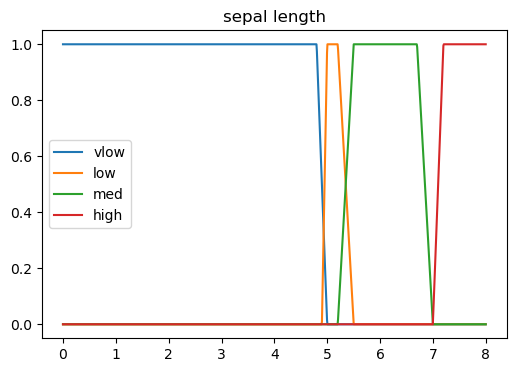

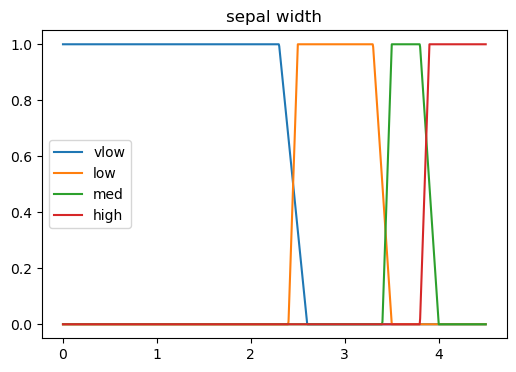

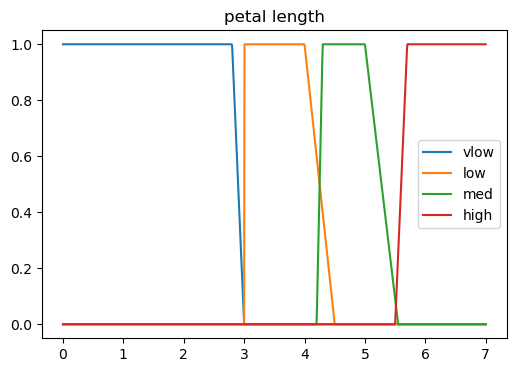

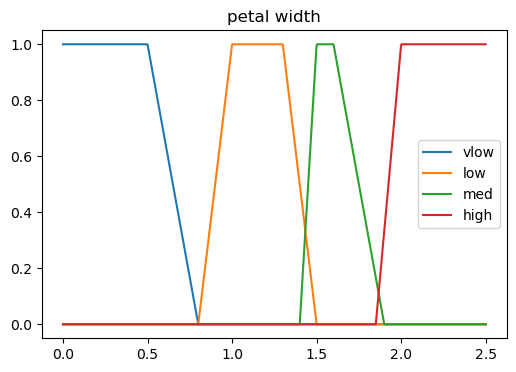

In [14]:

def plot_mfs(domain_mfs):
    plt.figure()
    for label,data in domain_mfs[2].items():
        plt.plot(domain_mfs[1],data,label=label)
        plt.title(domain_mfs[0])
        plt.legend()

for list in all_mfs:
    plot_mfs(list)

In [15]:

# # PUT IN DICTIONARY
# sl_mfs = {}
# sw_mfs = {}
# pl_mfs = {}
# pw_mfs = {}

# # populate sepal length dictionary
# sl_mfs['sl_low'] = sepal_length_low
# sl_mfs['sl_med'] = sepal_length_med
# sl_mfs['sl_high'] = sepal_length_high

# # populate sepal width dictionary
# sw_mfs['sw_low'] = sepal_width_low
# sw_mfs['sw_med'] = sepal_width_med
# sw_mfs['sw_high'] = sepal_width_high

# # populate petal length dictionary
# pl_mfs['pl_low'] = petal_length_low
# pl_mfs['pl_med'] = petal_length_med
# pl_mfs['pl_high'] = petal_length_high

# # populate petal width dictionary
# pw_mfs['pw_low'] = petal_width_low
# pw_mfs['pw_med'] = petal_width_med
# pw_mfs['pw_high'] = petal_width_high

Output membership functions

C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\3907819970.py:16: RuntimeWarning: divide by zero encountered in divide
  np.where((X >= a) & (X < b), (X - a) / (b - a),
C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\3907819970.py:16: RuntimeWarning: invalid value encountered in divide
  np.where((X >= a) & (X < b), (X - a) / (b - a),
C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\3907819970.py:18: RuntimeWarning: divide by zero encountered in divide
  np.where((X > c) & (X <= d), (d - X) / (d - c), 0.0))))
C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\3907819970.py:18: RuntimeWarning: invalid value encountered in divide
  np.where((X > c) & (X <= d), (d - X) / (d - c), 0.0))))


Text(0.5, 0, 'class 2 confidence')

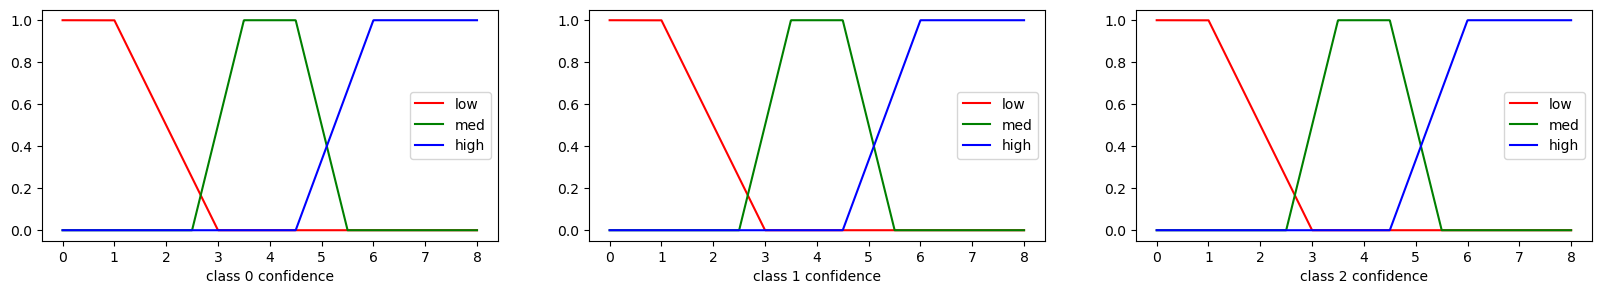

In [16]:
u_bound = 8
mid = u_bound/2
l_third = u_bound/3
u_third = u_bound - l_third
alpha = 1

class_0_domain = np.round(np.linspace(0, u_bound, 1000),3)


# class 0 subsets
class_0_low = trapezoid(class_0_domain, 0, 0, 1, 3)
class_0_med = trapezoid(class_0_domain, 2.5, 3.5, 4.5, 5.5)
class_0_high = trapezoid(class_0_domain, 4.5, 6, 8, 8)

# class 1 subsets
class_1_low = class_0_low.copy()
class_1_med = class_0_med.copy()
class_1_high = class_0_high.copy()

# class 1 subsets
class_2_low = class_0_low.copy()
class_2_med = class_0_med.copy()
class_2_high = class_0_high.copy()

# visualizing membership functions
fig, ax = plt.subplots(1,3,figsize=(20,3))
ax[0].plot(class_0_domain, class_0_low, "red", label='low')
ax[0].plot(class_0_domain, class_0_med, "green", label='med')
ax[0].plot(class_0_domain, class_0_high, "blue", label='high')
ax[0].legend()
ax[0].set_xlabel('class 0 confidence')

ax[1].plot(class_0_domain, class_1_low, "red", label='low')
ax[1].plot(class_0_domain, class_1_med, "green", label='med')
ax[1].plot(class_0_domain, class_1_high, "blue", label='high')
ax[1].legend()
ax[1].set_xlabel('class 1 confidence')

ax[2].plot(class_0_domain, class_2_low, "red", label='low')
ax[2].plot(class_0_domain, class_2_med, "green", label='med')
ax[2].plot(class_0_domain, class_2_high, "blue", label='high')
ax[2].legend()
ax[2].set_xlabel('class 2 confidence')

In [17]:
class_0_mfs = {}
class_1_mfs = {}
class_2_mfs = {}

class_0_mfs['low'] = class_0_low
class_0_mfs['med'] = class_0_med
class_0_mfs['high'] = class_0_high

class_1_mfs['low'] = class_1_low
class_1_mfs['med'] = class_1_med
class_1_mfs['high'] = class_1_high

class_2_mfs['low'] = class_2_low
class_2_mfs['med'] = class_2_med
class_2_mfs['high'] = class_2_high

output_mfs = [class_0_mfs, class_1_mfs, class_2_mfs]

Interpolate membership values

In [18]:
# for each data point, obtain its membership value in subsets of its domain

mem_values_sl = dict_of_dicts_to_dataframe(interp_mem_vals_of_data_all_subsets(sl_mfs[2], x_sl, data[:,0]))
mem_values_sw = dict_of_dicts_to_dataframe(interp_mem_vals_of_data_all_subsets(sw_mfs[2], x_sw, data[:,1]))
mem_values_pl = dict_of_dicts_to_dataframe(interp_mem_vals_of_data_all_subsets(pl_mfs[2], x_pl, data[:,2]))
mem_values_pw = dict_of_dicts_to_dataframe(interp_mem_vals_of_data_all_subsets(pw_mfs[2], x_pw, data[:,3]))

# create a list of dfs
mem_values_dfs = [mem_values_sl, mem_values_sw, mem_values_pl, mem_values_pw]

for df in mem_values_dfs:
    for col in df.columns[1:]:
        df[f'NOT_{col}'] = 1- df[col]


In [19]:
mem_values_pl

,Data point,vlow,low,med,high,NOT_vlow,NOT_low,NOT_med,NOT_high
0,1.4,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
1,1.3,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
2,1.5,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
3,1.7,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
4,1.6,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
5,1.1,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
6,1.2,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
7,1.0,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
8,1.9,1.00000,0.00000,0.00000,0.00000,0.00000,1.00000,1.00000,1.00000
9,4.7,0.00000,0.00000,1.00000,0.00000,1.00000,1.00000,0.00000,1.00000


Rule base

In [20]:
rule_base_0 = []
rule_base_1 = []
rule_base_2 = []




add_rule(rule_base_0, "IF sepal length is VLOW THEN class 0 is HIGH")
add_rule(rule_base_0, "IF sepal length is LOW THEN class 0 is MED")
add_rule(rule_base_0, "IF sepal width is HIGH THEN class 0 is HIGH")
add_rule(rule_base_0, "IF petal length is VLOW THEN class 0 is HIGH")
add_rule(rule_base_0,"IF petal width is VLOW THEN class 0 is HIGH")
add_rule(rule_base_0, "IF sepal width is MED THEN class 0 is HIGH")
add_rule(rule_base_0,"IF sepal width is LOW THEN class 0 is MED")

add_rule(rule_base_1,"IF petal length is LOW OR petal width is LOW THEN class 1 is HIGH")
add_rule(rule_base_1,"IF sepal length is MED THEN class 1 is LOW")

add_rule(rule_base_2,"IF sepal length is HIGH OR petal width is HIGH OR petal length is HIGH THEN class 2 is HIGH")
add_rule(rule_base_2,"IF sepal width is MED THEN class 2 is LOW")
add_rule(rule_base_2,"IF sepal length is MED THEN class 2 is MED")
add_rule(rule_base_2,"IF sepal width is LOW THEN class 2 is HIGH")
add_rule(rule_base_2,"IF petal width is MED THEN class 2 is MED")

rule_bases = [rule_base_0,rule_base_1,rule_base_2]

# rows = max(len(rule_base) for rule_base in rule_bases)

# for rule_base in rule_bases:
#     while len(rule_base) < rows:
#         rule_base.append(None)

# print(rule_bases)
# rule_bases_df = pd.DataFrame(rule_bases).T
# path = "C:/Users/Zayan/Documents/code/personal_repos/fuzzy_cls_reg/results/3"
# rule_bases_df.to_csv(f"{path}/rules.csv", index=False)

Rule with same consquent exists. Thus, previous rule will be extended with this rule with an OR
Old rule: IF sepal length is VLOW THEN class 0 is HIGH 
Current rule: IF sepal width is HIGH THEN class 0 is HIGH
New rule: IF sepal length is VLOW OR sepal width is HIGH THEN class 0 is HIGH
Rule with same consquent exists. Thus, previous rule will be extended with this rule with an OR
Old rule: IF sepal length is VLOW THEN class 0 is HIGH 
Current rule: IF petal length is VLOW THEN class 0 is HIGH
New rule: IF sepal length is VLOW OR petal length is VLOW THEN class 0 is HIGH
Rule with same consquent exists. Thus, previous rule will be extended with this rule with an OR
Old rule: IF sepal length is VLOW THEN class 0 is HIGH 
Current rule: IF petal width is VLOW THEN class 0 is HIGH
New rule: IF sepal length is VLOW OR petal width is VLOW THEN class 0 is HIGH
Rule with same consquent exists. Thus, previous rule will be extended with this rule with an OR
Old rule: IF sepal length is VLOW THEN

Inference

# Run Classification on dataset

In [21]:
iris_df['predicted'] = iris_df.apply(lambda x: classify(proposition=x,
                                      rule_bases=rule_bases,
                                      mem_values_dfs=mem_values_dfs,
                                      list_of_output_mf_dicts=output_mfs,
                                      output_X=class_0_domain,
                                      agg_method='max',
                                      defuzzifier='centroid',
                                      decision_basis='confidence'), axis=1 )

iris_df

Aggregate is totally 0
0
Aggregate is totally 0
2
Aggregate is totally 0
2
Aggregate is totally 0
2
Aggregate is totally 0
0
0
Aggregate is totally 0
2
Aggregate is totally 0
2
Aggregate is totally 0
2
Aggregate is totally 0
2
0
Aggregate is totally 0
2
Aggregate is totally 0
2
Aggregate is totally 0
2
0
0


C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\1636734254.py:11: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sl_input = proposition[0]
C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\1636734254.py:12: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  sw_input = proposition[1]
C:\Users\Zayan\AppData\Local\Temp\ipykernel_9448\1636734254.py:13: FutureWarning: Series.__getitem__ treating keys as positions is deprecated. In a future version, integer keys will always be treated as labels (consistent with DataFrame behavior). To access a value by position, use `ser.iloc[pos]`
  pl_input = proposition[2]
C:\Users\Zayan\AppD

0
Aggregate is totally 0
0
0
Aggregate is totally 0
0
0
Aggregate is totally 0
0
Aggregate is totally 0
0
Aggregate is totally 0
2
Aggregate is totally 0
2
Aggregate is totally 0
2
Aggregate is totally 0
2
0
2
Aggregate is totally 0
2
Aggregate is totally 0
2
0
0
0
Aggregate is totally 0
2
Aggregate is totally 0
2
0
Aggregate is totally 0
0
Aggregate is totally 0
2
Aggregate is totally 0
2
Aggregate is totally 0
0
Aggregate is totally 0
Aggregate is totally 0
0
Aggregate is totally 0
2
Aggregate is totally 0
0
Aggregate is totally 0
0
Aggregate is totally 0
2
Aggregate is totally 0
0
Aggregate is totally 0
2
0
Aggregate is totally 0
2
2
2
2
1
2
2
2
1
2
2
Aggregate is totally 0
1
2
Aggregate is totally 0
1
2
2
2
2
2
Aggregate is totally 0
2
2
2
2
2
2
2
2
2
2
2
2
1
1
2
2
2
2
2
Aggregate is totally 0
1
2
2
2
2
2
Aggregate is totally 0
1
2
2
2
2
1
2
2
2
Aggregate is totally 0
2
2
2
Aggregate is totally 0
2
1
Aggregate is totally 0
2
2
Aggregate is totally 0
0
2
2
2
2
2
2
2
Aggregate is tot

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target,predicted
0,5.1,3.5,1.4,0.2,0,0
1,4.9,3.0,1.4,0.2,0,2
2,4.7,3.2,1.3,0.2,0,2
3,4.6,3.1,1.5,0.2,0,2
4,5.0,3.6,1.4,0.2,0,0
...,...,...,...,...,...,...
145,6.7,3.0,5.2,2.3,2,2
146,6.3,2.5,5.0,1.9,2,2
147,6.5,3.0,5.2,2.0,2,2
148,6.2,3.4,5.4,2.3,2,2


Performance

In [22]:
cm = metrics.confusion_matrix(y_true=iris_df['target'], y_pred=iris_df['predicted'])
score = metrics.accuracy_score(iris_df['target'], iris_df['predicted'])

In [23]:
score

0.5333333333333333

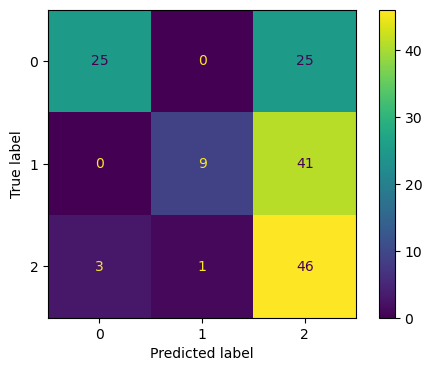

In [24]:
cm_display = metrics.ConfusionMatrixDisplay(cm).plot()

# Visualization

IF sepal length is VLOW THEN class 0 is HIGH
[7.  3.2 4.7 1.4]
[0.0]


NameError: name 'sepal_length_domain' is not defined

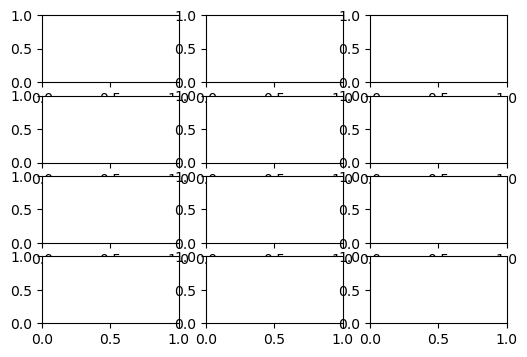

In [25]:
input_data = data[50,:]

rule0 = rule_base_0[0]
rule1 = rule_base_0[1]
rule2 = rule_base_0[2]

print(rule0)
print(input_data)

membership_values = get_mem_vals_from_rule(input_data, rule0, mem_values_dfs)
print(membership_values)

fig, ax = plt.subplots(4,3)

# plot mf
ax[0,0].plot(sepal_length_domain, sepal_length_low, label='low')
ax[0,0].plot(sepal_length_domain, sepal_length_med, label='med')
ax[0,0].plot(sepal_length_domain, sepal_length_high, label='high')
ax[0,0].legend()
ax[0,0].set_xlabel('sepal length')

# fill
ax[0,0].plot([input_data[0], input_data[0]], [0, membership_values[0]])
ax[0,0].fill_between(sepal_length_domain, np.fmin(sepal_length_high, membership_values[0]))

# plot mf
ax[1,0].plot(petal_length_domain, petal_length_low, label='low')
ax[1,0].plot(petal_length_domain, petal_length_med, label='med')
ax[1,0].plot(petal_length_domain, petal_length_high, label='high')
ax[1,0].legend()
ax[0,0].set_xlabel('petal length')

# fill
ax[1,0].plot([input_data[2], input_data[2]], [0, membership_values[2]])
ax[1,0].fill_between(petal_length_domain, np.fmin(petal_length_low, membership_values[2]), alpha = 0.3)
# ax[1,0].fill_between(petal_length_domain, membership_values[2], alpha = 0.3)


plt.tight_layout()
